alphas.shape=(179,)
y.shape=(49225,)
Np=15
C.shape=(2, 100)


100%|██████████| 3/3 [00:00<00:00, 1499.93it/s]

p.shape=(100,)
p, [ 5.6768581   6.51552867  7.35419924  8.19286981  9.03154037  9.87021094
 10.70888151 11.54755208 12.38622265 13.22489321  5.13221907  5.97088963
  6.8095602   7.64823077  8.48690134  9.32557191 10.16424247 11.00291304
 11.84158361 12.68025418  4.58758003  5.4262506   6.26492117  7.10359174
  7.9422623   8.78093287  9.61960344 10.45827401 11.29694458 12.13561514
  4.042941    4.88161156  5.72028213  6.5589527   7.39762327  8.23629384
  9.0749644   9.91363497 10.75230554 11.59097611  3.49830196  4.33697253
  5.1756431   6.01431367  6.85298423  7.6916548   8.53032537  9.36899594
 10.20766651 11.04633707  2.95366293  3.79233349  4.63100406  5.46967463
  6.3083452   7.14701577  7.98568633  8.8243569   9.66302747 10.50169804
  2.40902389  3.24769446  4.08636503  4.9250356   5.76370616  6.60237673
  7.4410473   8.27971787  9.11838844  9.957059    1.86438486  2.70305542
  3.54172599  4.38039656  5.21906713  6.0577377   6.89640826  7.73507883
  8.5737494   9.41241997  1.31974

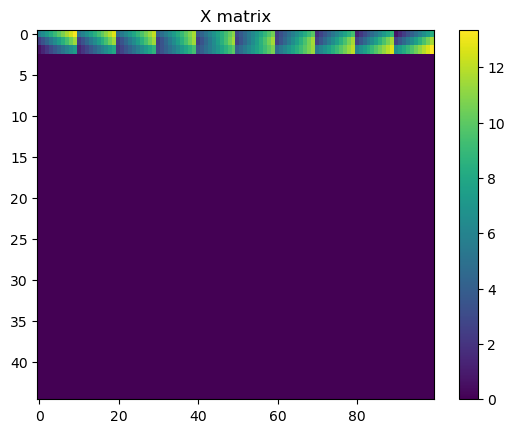

In [25]:
import numpy as np
from scipy.sparse import coo_matrix
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

def construct_X(M, alphas, Np=None):
    if Np is None:
        Np = int(np.ceil(np.sqrt(2) * M))
    if Np % 2 == 0:
        Np = Np + 1 # get an odd number for Np
    print(f"Np={Np}")

    D = M * M
    No = len(alphas)
    N = Np * No

    h = 1
    a0 = -(M - 1) / 2 # -(M - 1) / 2
    b0 = -(M - 1) / 2 # -(M - 1) / 2
    s0= (Np - 1) / 2
    ja = np.mgrid[0:D] % M
    jb = np.mgrid[0:D] // M
    C = np.stack((a0 + ja * h, b0 + jb * h))
    print(f"C.shape={C.shape}")

    i_indices = []
    j_indices = []
    weights = []

    for alpha_idx in tqdm(range(len(alphas))):
        alpha = alphas[alpha_idx]
        n = np.array([np.cos(np.deg2rad(alpha)), np.sin(np.deg2rad(alpha))])
        # p = np.dot(C.transpose((1, 2, 0)), n) + 1
        p = np.dot(n, C) + s0
        print(f"p.shape={p.shape}")
        p = p % Np
        print("p,",p)

        mask = np.logical_and(p > 0, p < Np)
        indices = np.where(mask)[0]
        # indices = p
        print(f"indices.shape={indices.shape}")
        print("indices,",indices)
        
        if len(indices) > 0:
            i_indices.extend([alpha_idx] * len(indices))
            j_indices.extend(indices)
            weights.extend(p[indices]) 
            print("extended weights:",p[indices])
            # weights.extend(p[indices])
            print(len(i_indices),len(j_indices),len(weights))

    X = coo_matrix((weights, (i_indices, j_indices)), shape=(N, D), dtype=np.float32)
    print("X",X)
    return X

data_path = "./data/"

y = np.load(os.path.join(data_path, "y_195.npy"))
alphas = np.load(os.path.join(data_path, "alphas_195.npy"))

# Example usage
print(f"alphas.shape={alphas.shape}")
print(f"y.shape={y.shape}")
M = y.shape[0]
# X = construct_X(M, alphas)
alphas=[-33,1,42]
X = construct_X(10, alphas)

# Convert sparse matrix to dense numpy array for visualization
X_dense = X.toarray()
print(X_dense.shape)
print(X_dense)

# Visualize the matrix with the adjusted color scale
plt.imshow(X_dense, cmap='viridis', aspect='auto')
plt.colorbar()
plt.title('X matrix')
plt.show()
